# The impact of dosing strategies on outcomes in NSCLC 

Simulation of MTD, adaptive, and metronomic dosing in NSCLC with model fitting to patient-derived tumor growth data.

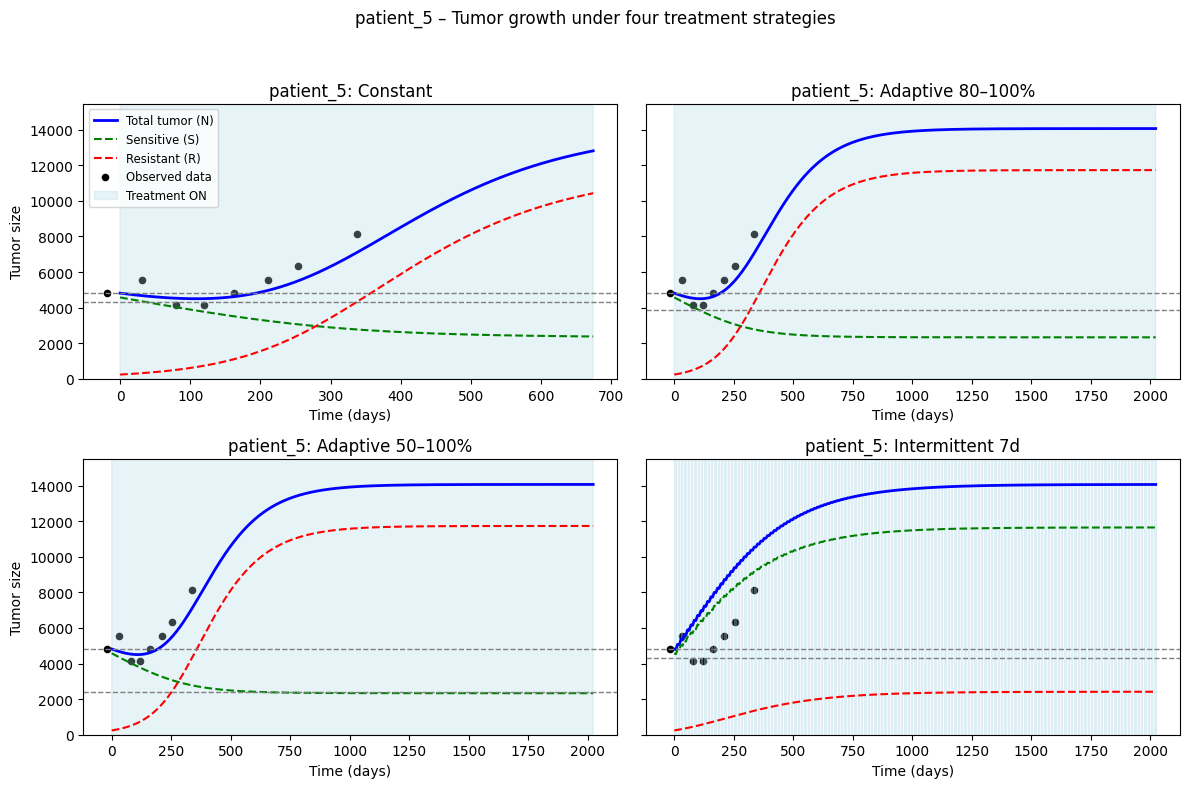

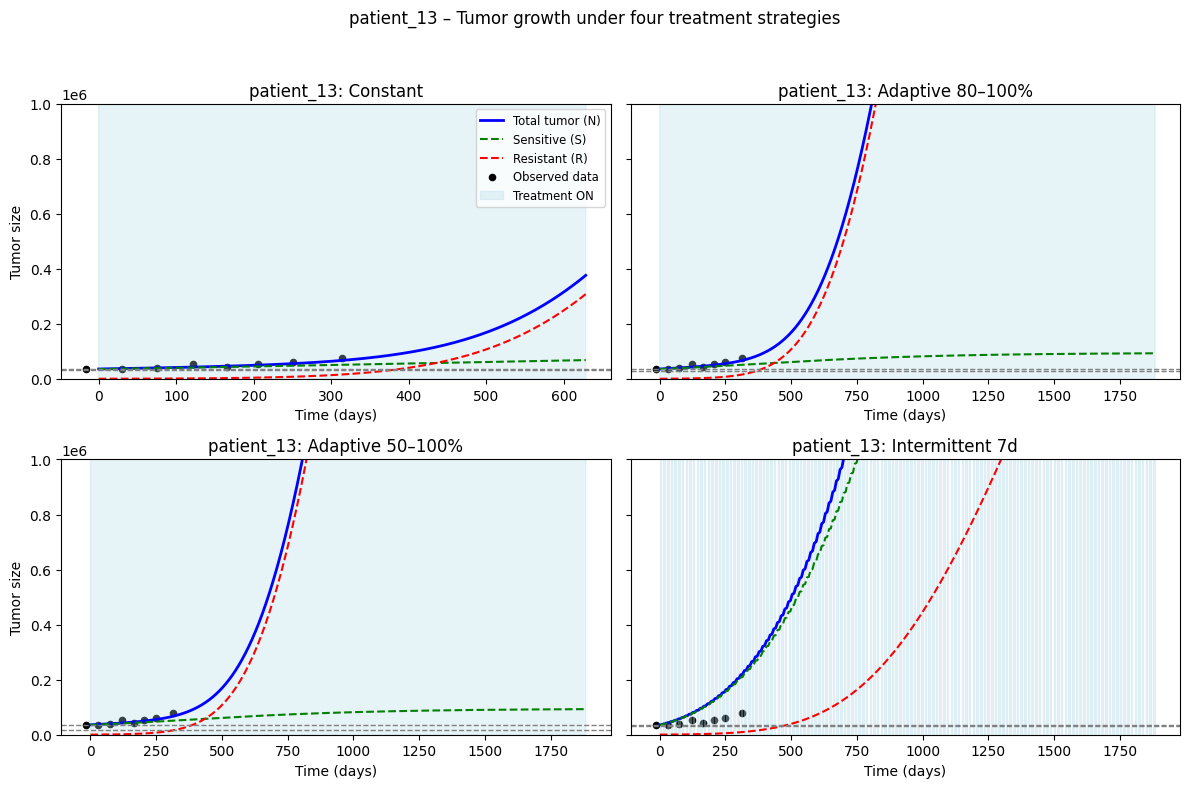

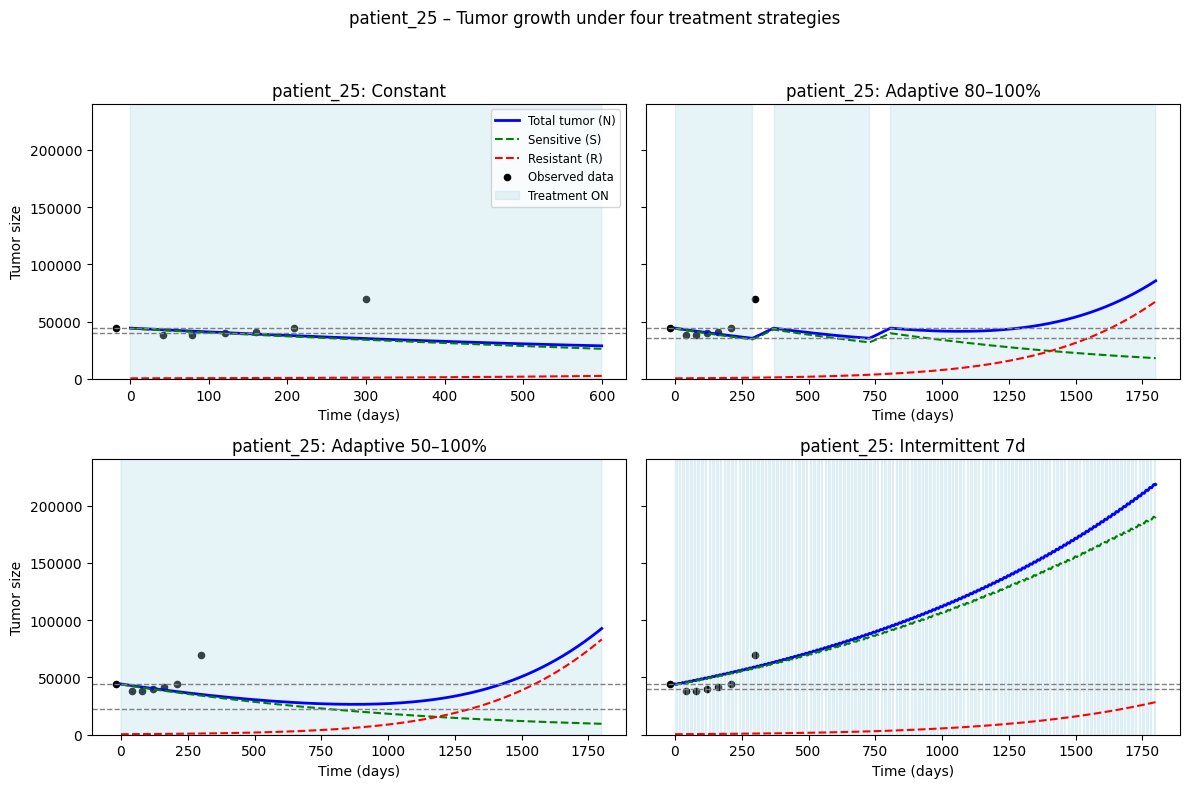

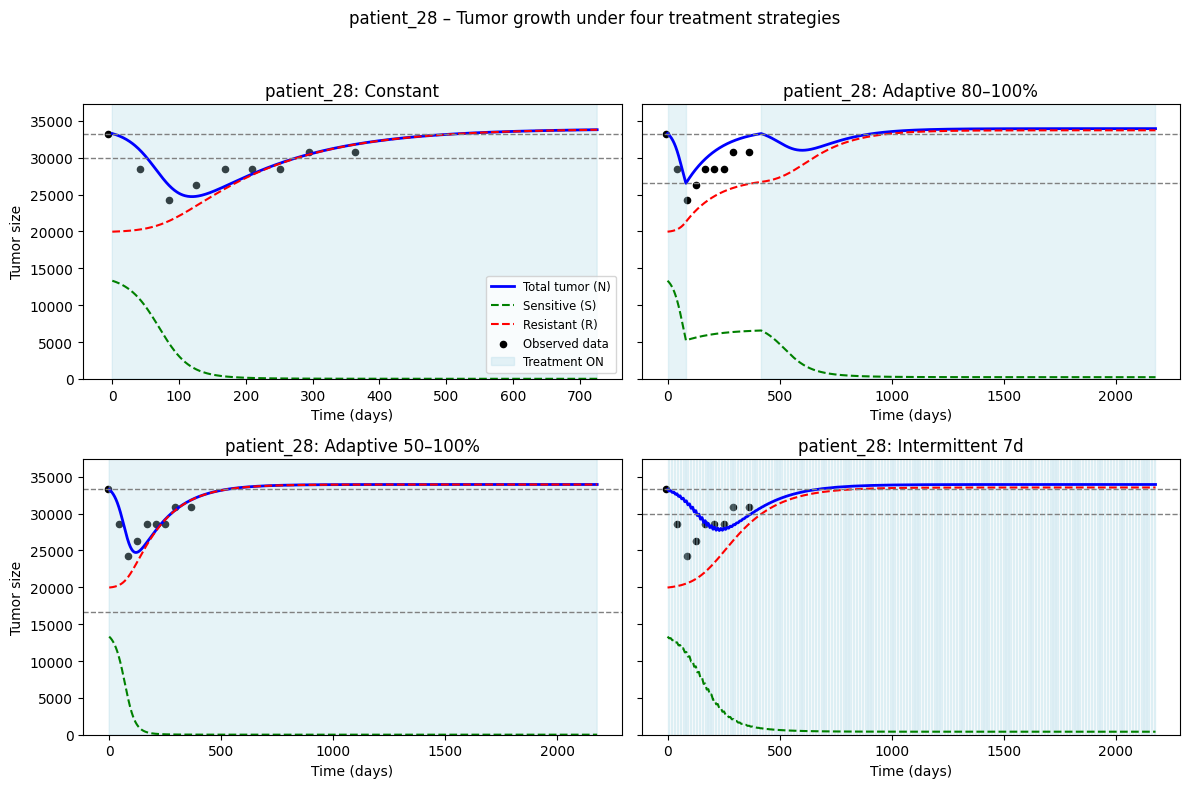

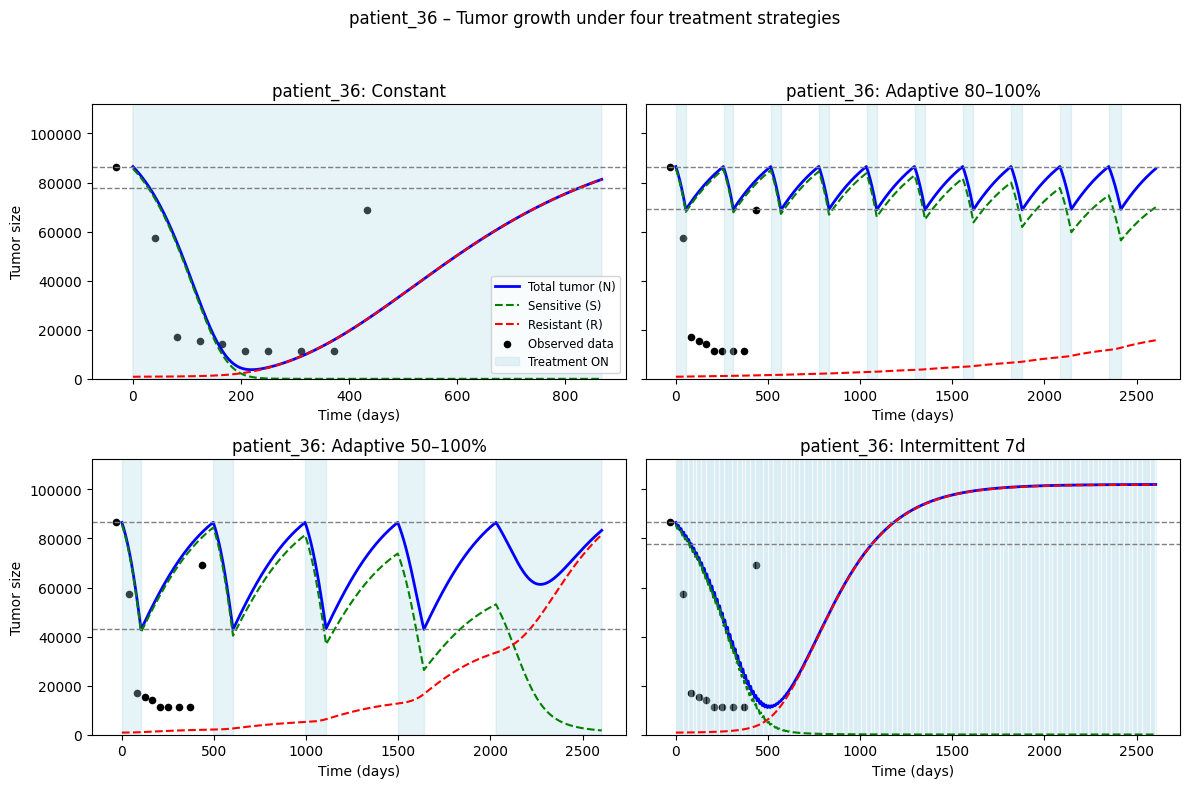

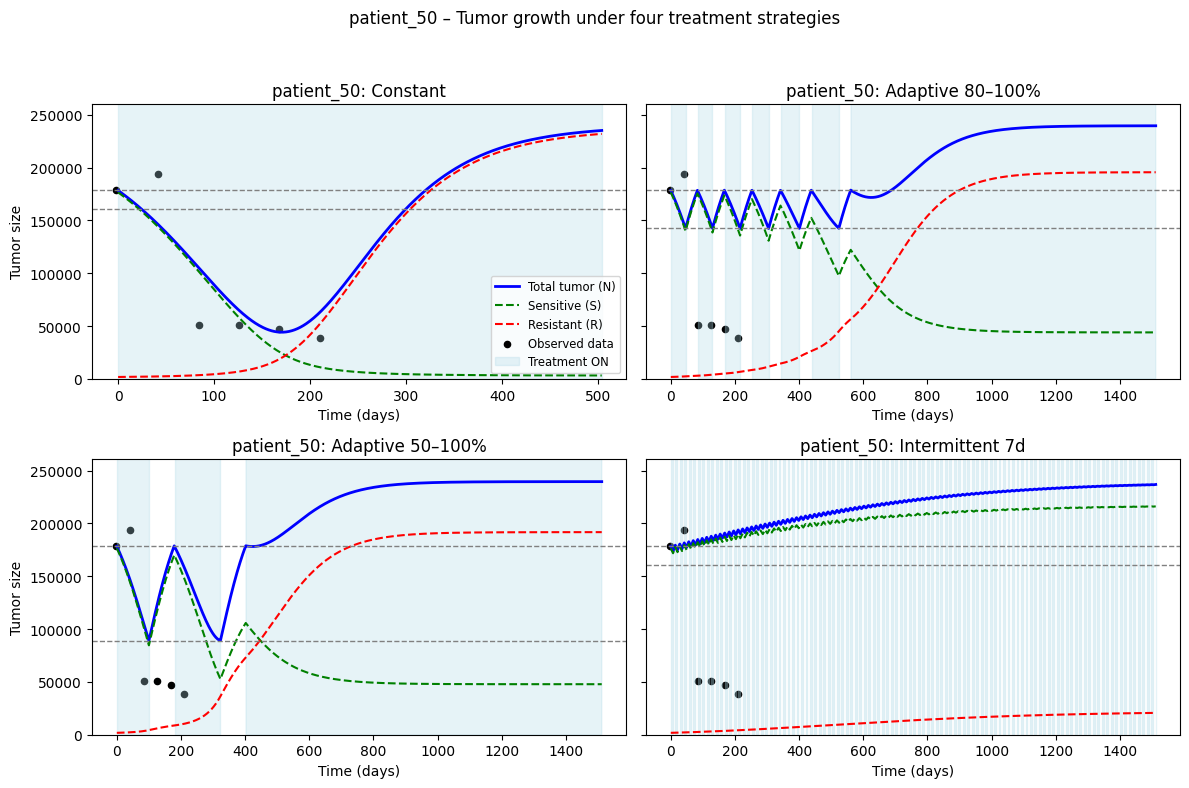

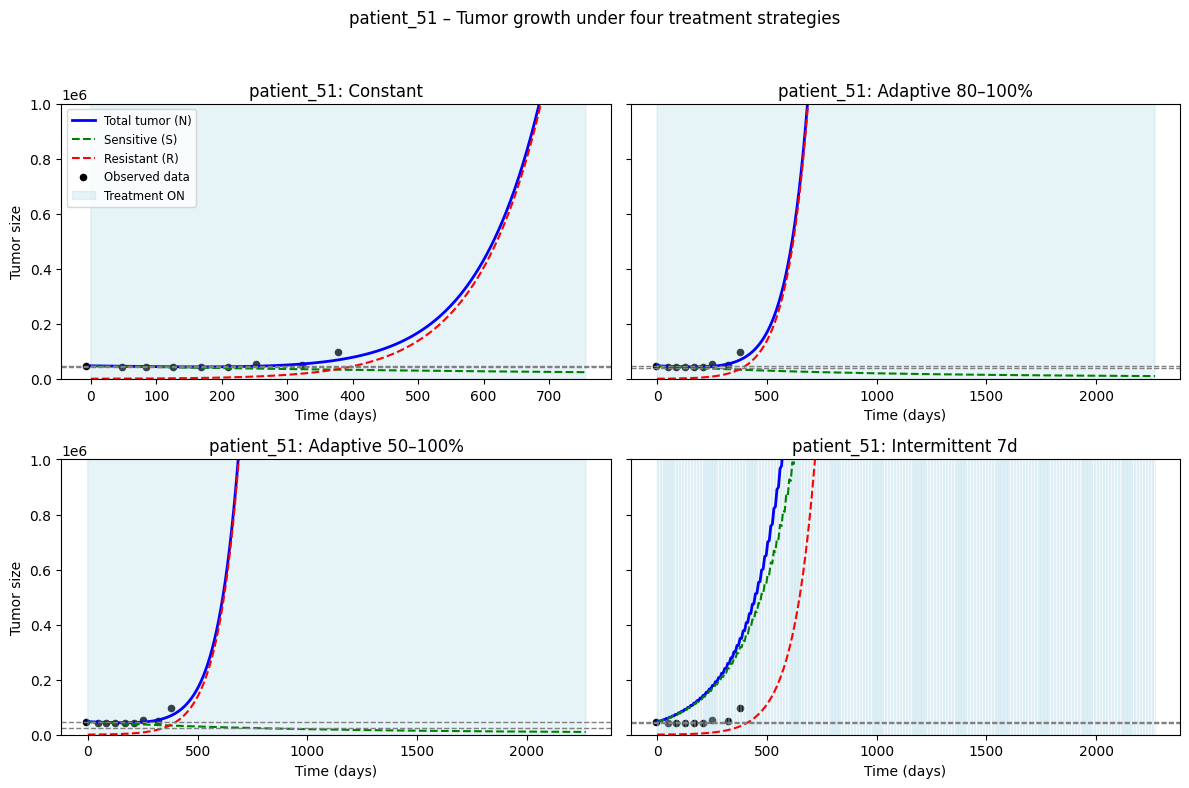

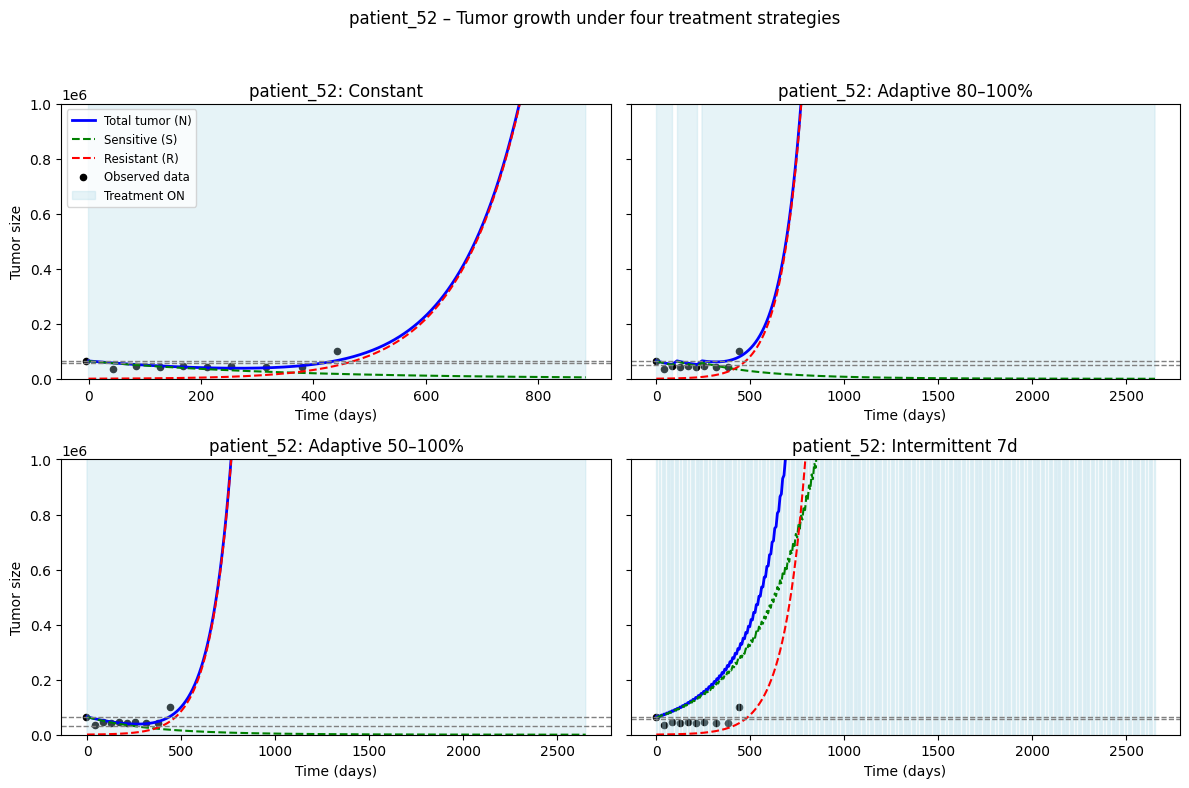

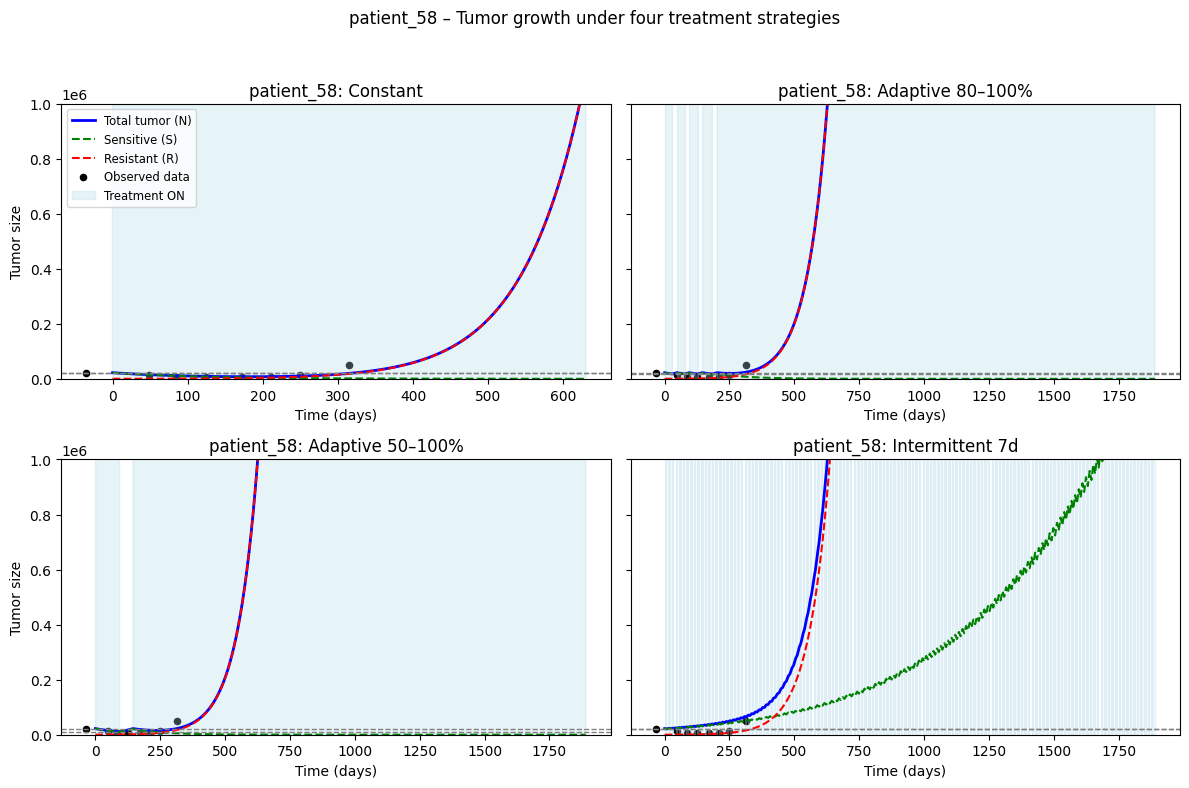

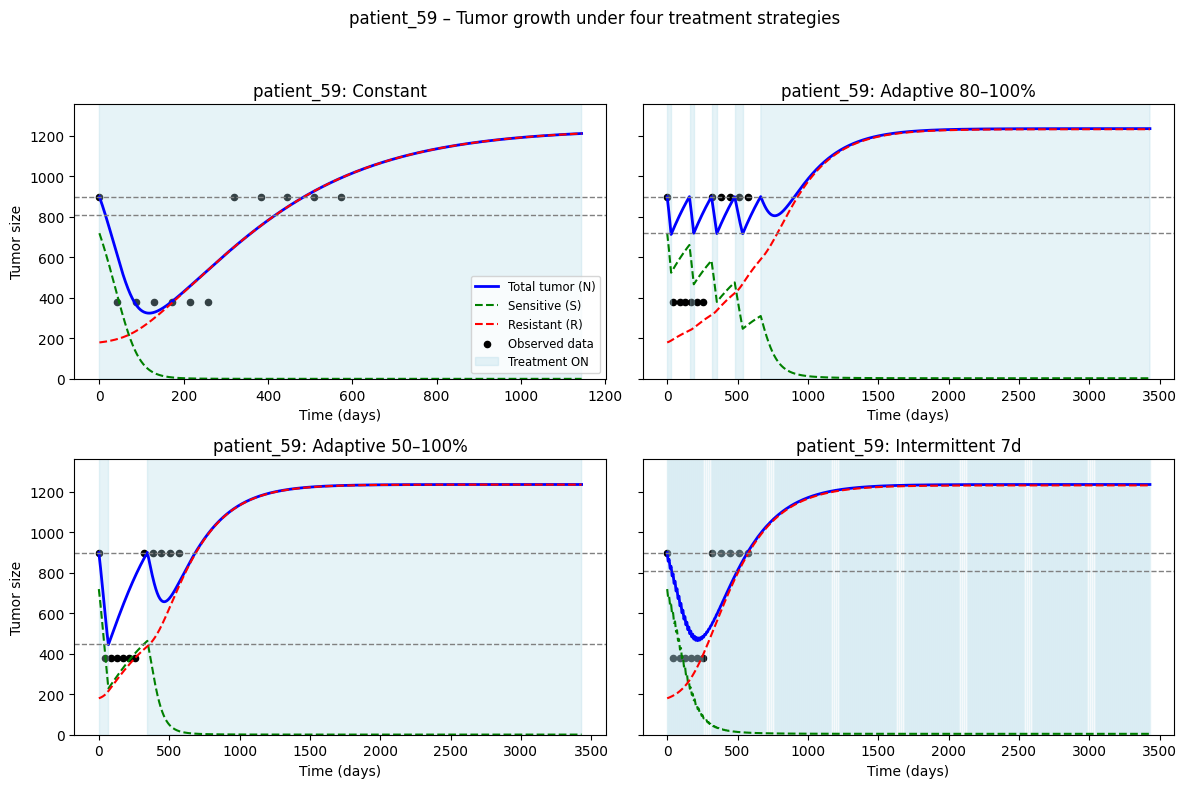

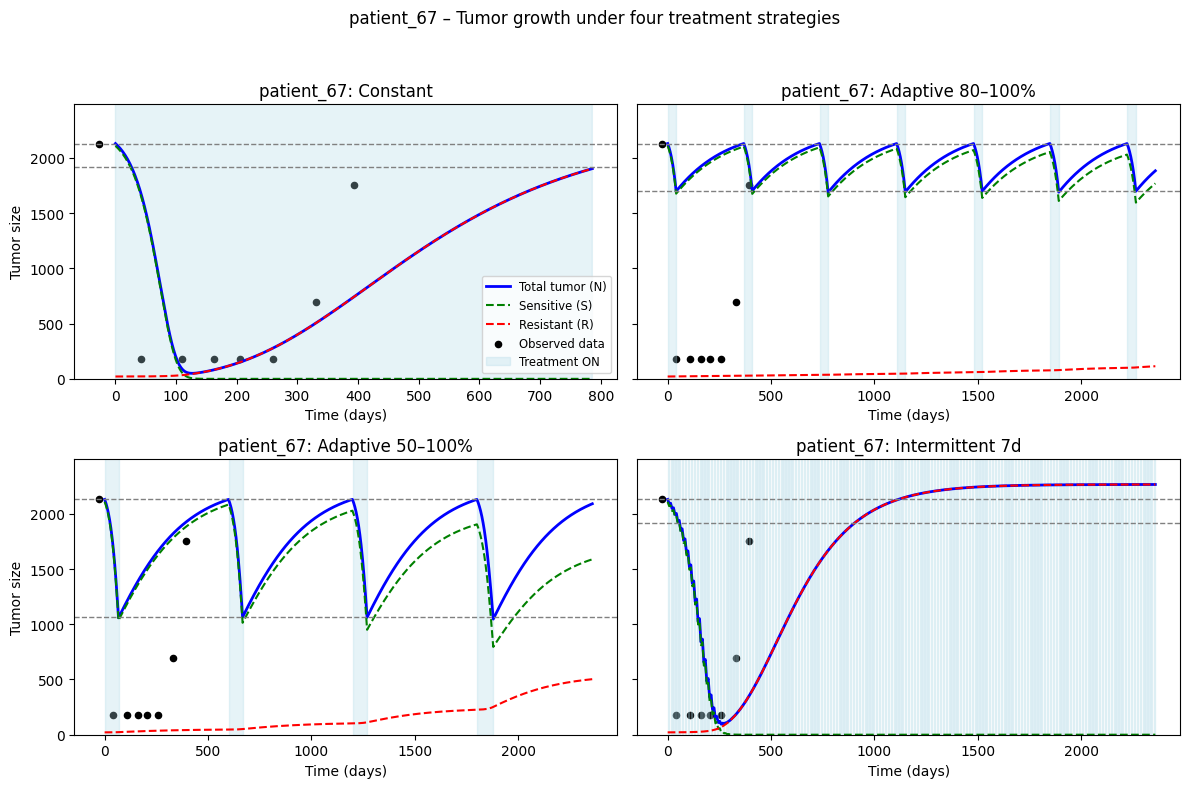

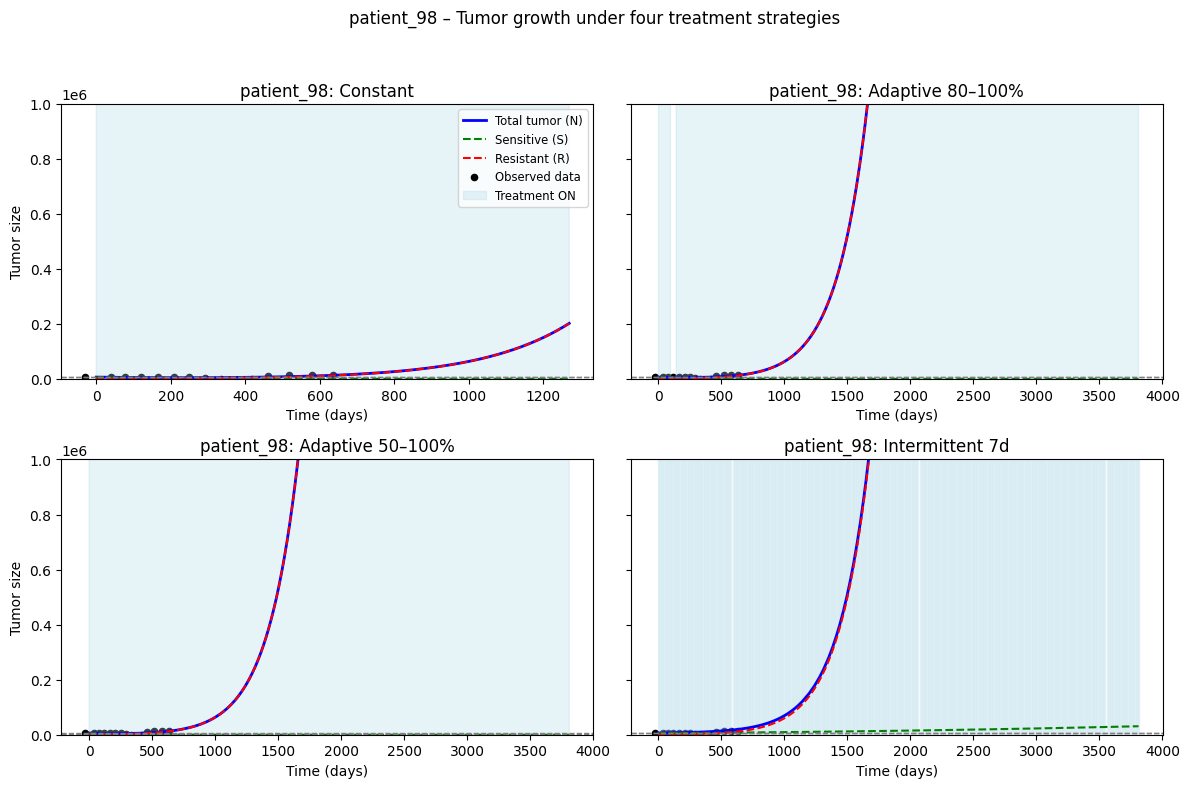

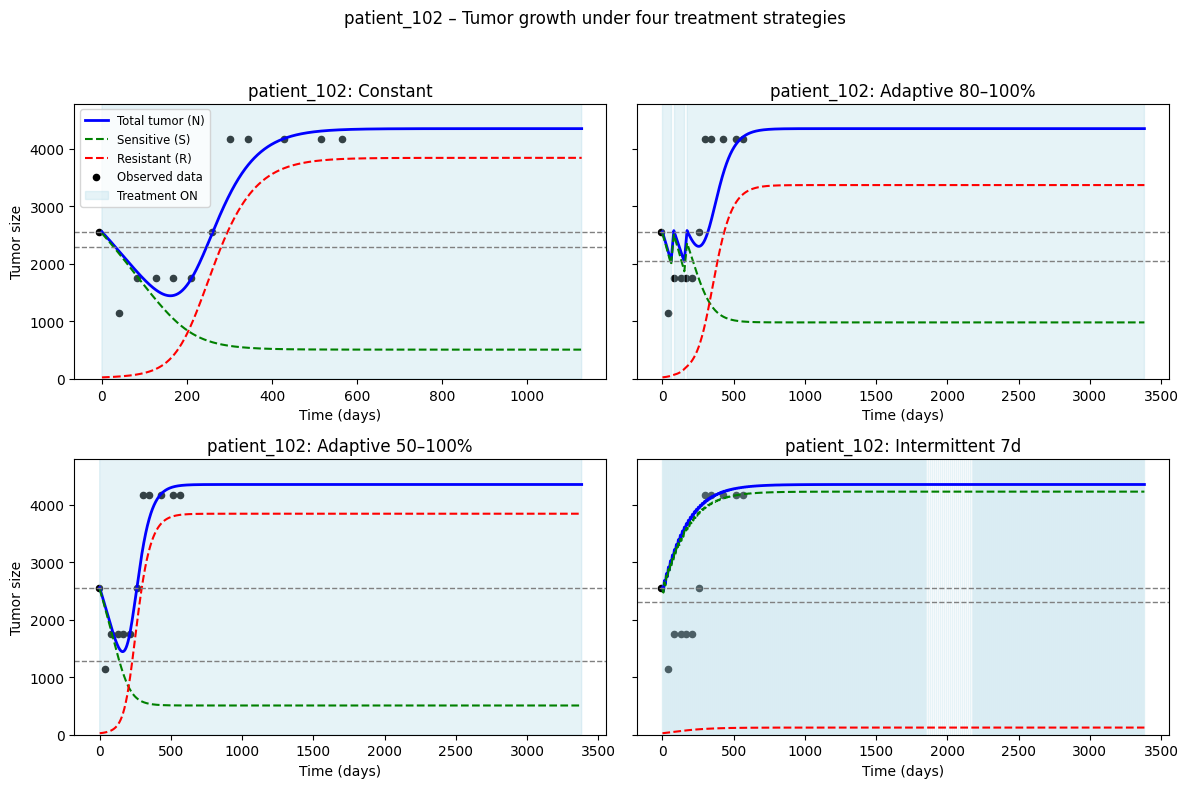

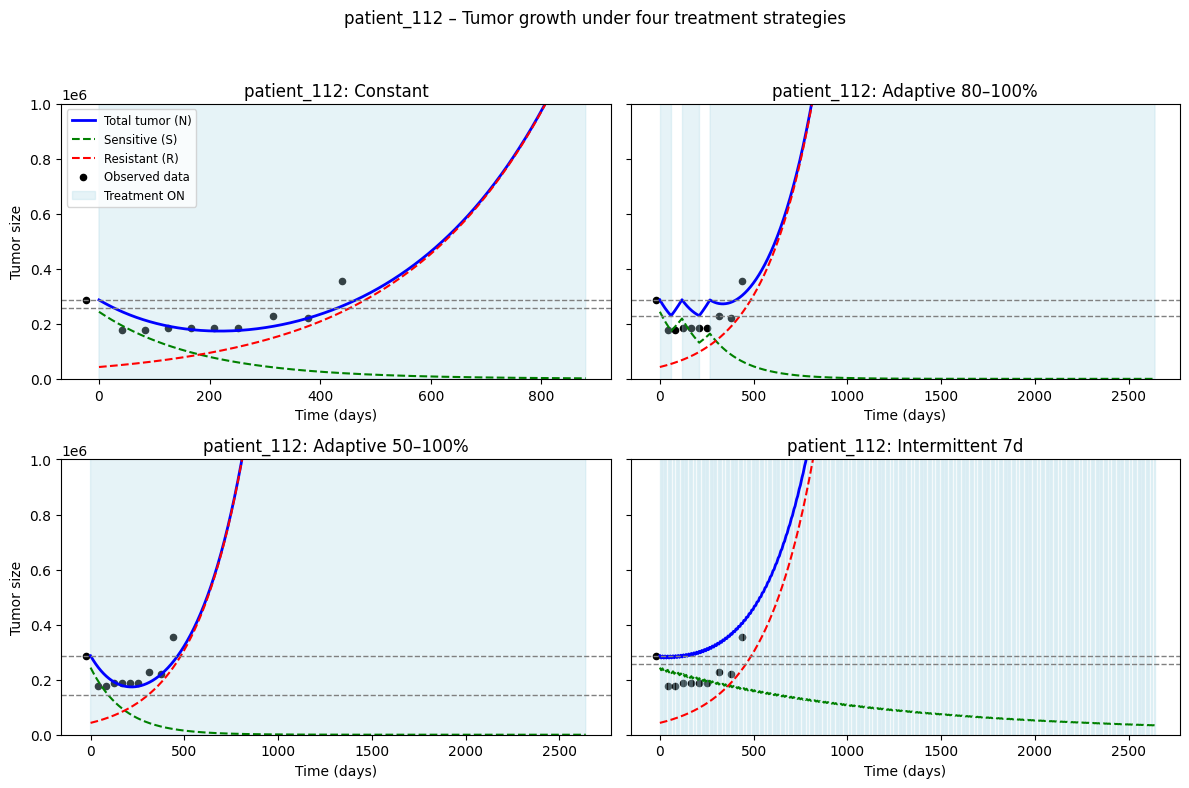

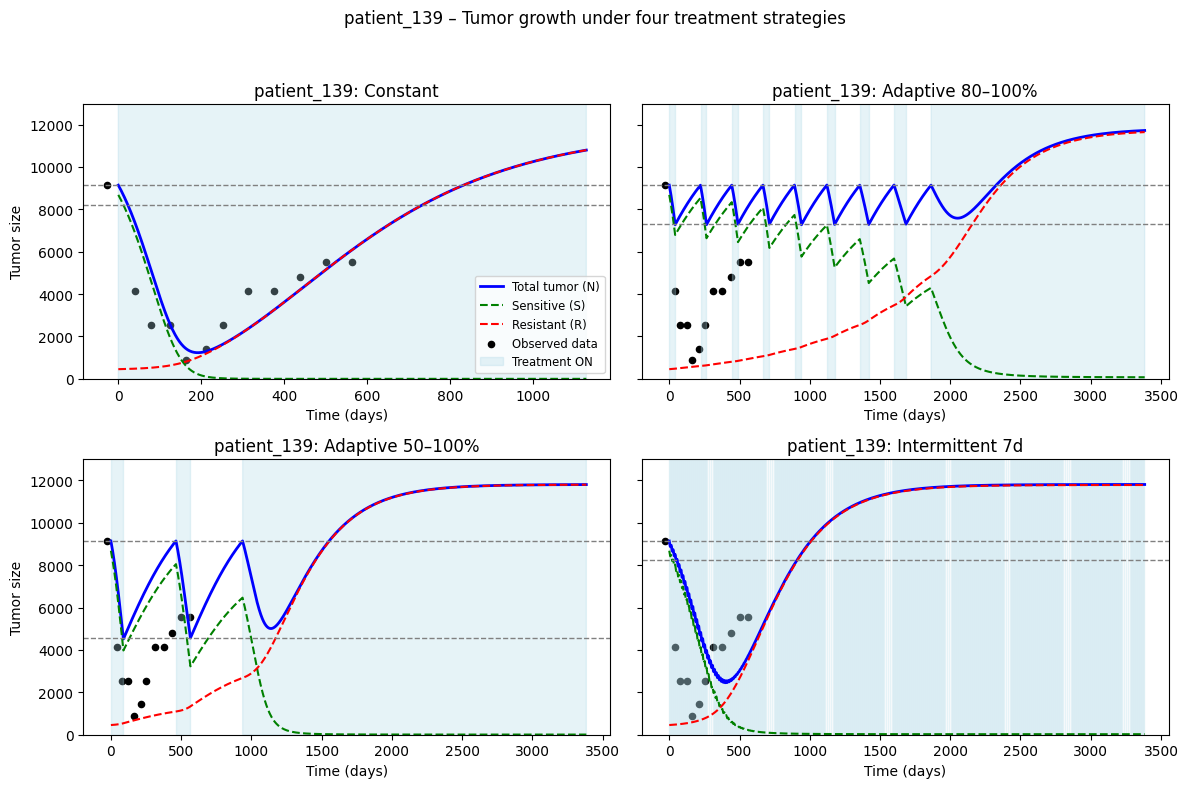

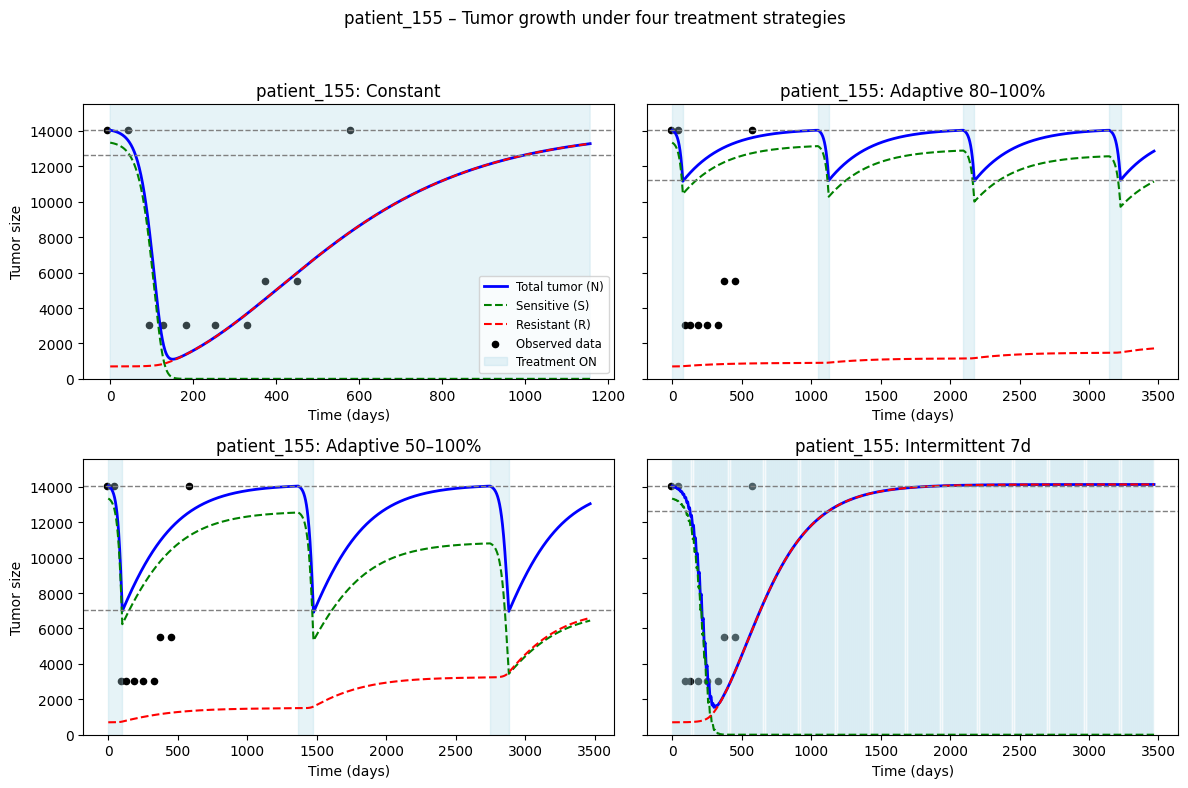

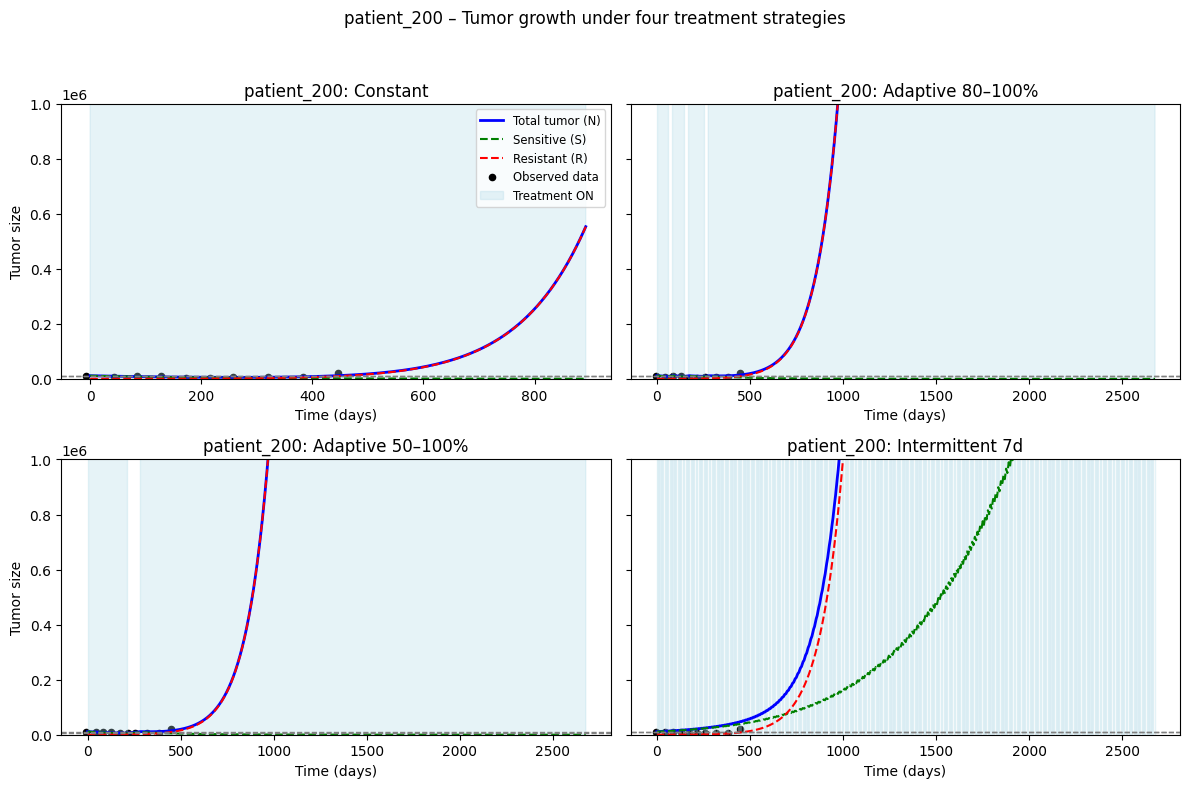

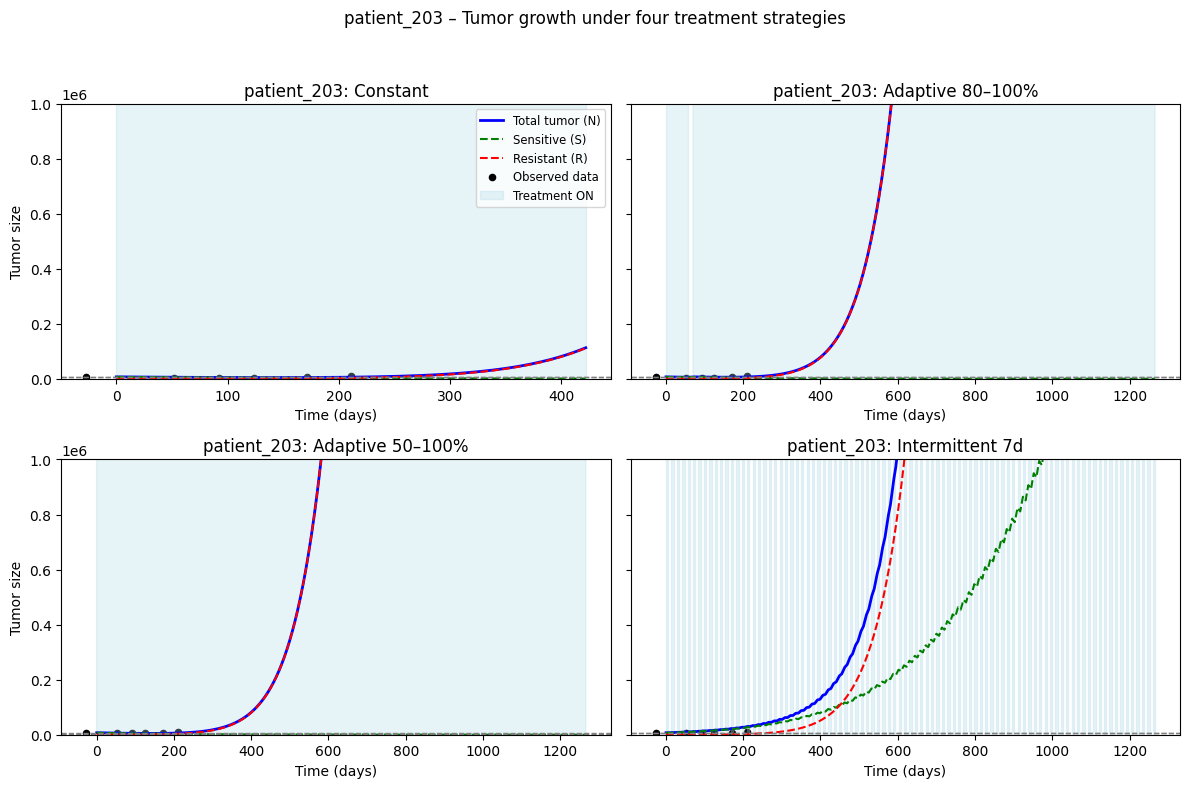

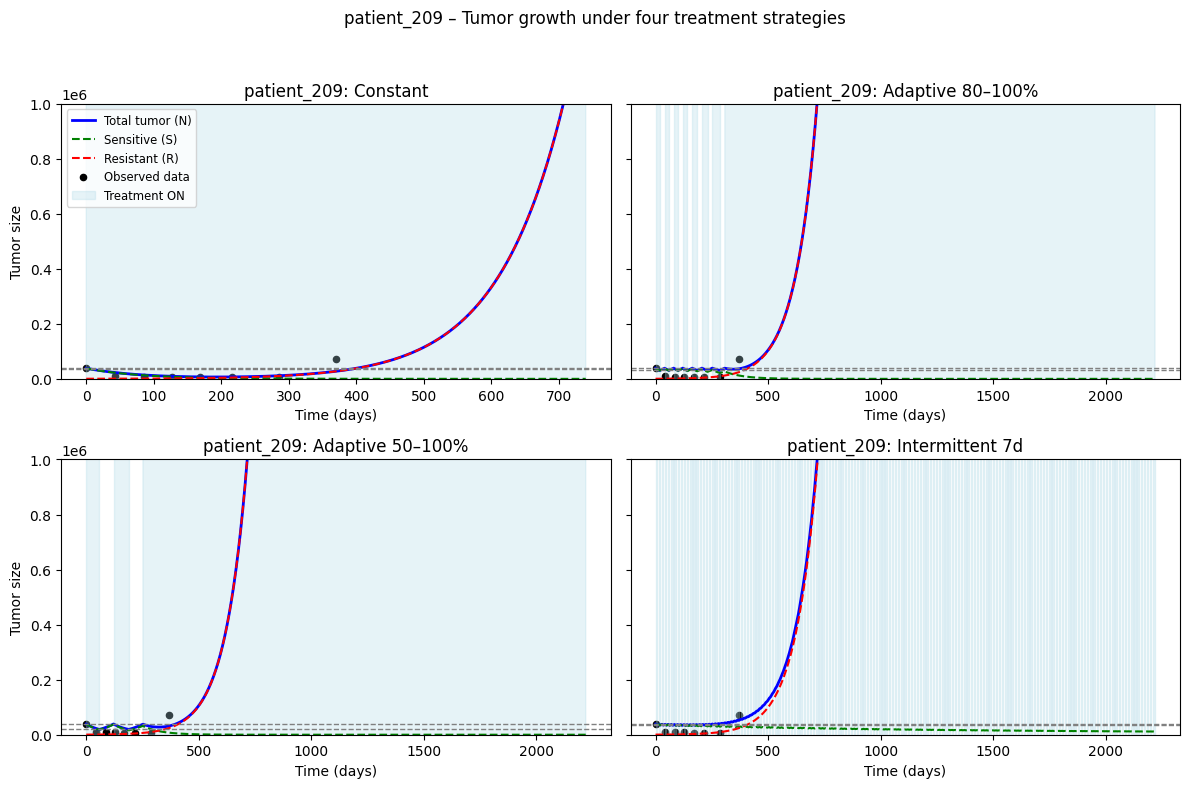

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# === Load Excel data ===
# Data consists of tumor volume and fitted parameters for each patient from Soboleva et al. (2025)
xls = pd.ExcelFile('patient_trends.xlsx')
patients = [s for s in xls.sheet_names if s.startswith('patient_')]

# === Define simulation using polymorphic Gompertzian model with given treatment profile ===
def simulate_profile(rho, gamma, K, p_val, N0, days, C_profile):
    S_vals = [p_val * N0]
    R_vals = [(1 - p_val) * N0]
    for i in range(1, len(days)):
        C_t = C_profile[i - 1]
        def deriv(N, t):
            S, R = N
            total = S + R
            dS = rho * (1 - gamma * C_t) * np.log(K / total) * S
            dR = rho * np.log(K / total) * R
            return [dS, dR]
        tspan = [days[i - 1], days[i]]
        sol = odeint(deriv, [S_vals[-1], R_vals[-1]], tspan)
        S_vals.append(sol[-1][0])
        R_vals.append(sol[-1][1])
    S = np.array(S_vals)
    R = np.array(R_vals)
    return S, R, S + R

# === Define adaptive treatment model using hysteresis and full simulation ===
def simulate_adaptive_odeint_full(rho, gamma, K, p_val, N0, days, lower_frac):
    upper_thr = N0
    lower_thr = lower_frac * N0
    S_vals = [p_val * N0]
    R_vals = [(1 - p_val) * N0]
    C_vals = [1]  # start with treatment ON

    for i in range(1, len(days)):
        N_prev = S_vals[-1] + R_vals[-1]
        # Apply switching logic
        if C_vals[-1] == 1 and N_prev <= lower_thr:
            C_new = 0
        elif C_vals[-1] == 0 and N_prev >= upper_thr:
            C_new = 1
        else:
            C_new = C_vals[-1]
        C_vals.append(C_new)

        def deriv(N, t):
            S, R = N
            total = S + R
            dS = rho * (1 - gamma * C_new) * np.log(K / total) * S
            dR = rho * np.log(K / total) * R
            return [dS, dR]

        tspan = [days[i - 1], days[i]]
        sol = odeint(deriv, [S_vals[-1], R_vals[-1]], tspan)
        S_vals.append(sol[-1][0])
        R_vals.append(sol[-1][1])

    S = np.array(S_vals)
    R = np.array(R_vals)
    N = S + R
    C = np.array(C_vals)
    return S, R, N, C

# === Store simulation results ===
records = []

for pid in patients:
    if pid in ['patient_137', 'patient_223', 'patient_89']:  # Skip patients with unstable or missing data
        continue

    df = pd.read_excel(xls, sheet_name=pid)
    t_data = df['time'].dropna().astype(float).values
    y_data = df['Data'].dropna().astype(float).values
    if len(t_data) == 0:
        continue

    rho, gamma = df['rho'].iloc[0], df['gamma'].iloc[0]
    p_val, K = df['props'].iloc[0], df['K'].iloc[0]
    N0 = y_data[0]

    # === Time spans for each strategy ===
    t_const = np.arange(0, int(t_data.max() * 2) + 1)
    t_ad = np.arange(0, int(t_data.max() * 6) + 1)

    # 1) Constant
    C_const = np.ones_like(t_const)
    S_const, R_const, N_const = simulate_profile(rho, gamma, K, p_val, N0, t_const, C_const)

    # 2) Adaptive 80–100%
    S_a80, R_a80, N_a80, C80 = simulate_adaptive_odeint_full(rho, gamma, K, p_val, N0, t_ad, 0.80)

    # 3) Adaptive 50–100%
    S_a50, R_a50, N_a50, C50 = simulate_adaptive_odeint_full(rho, gamma, K, p_val, N0, t_ad, 0.50)

    # 4) Intermittent 7d on/off
    C_int_full = ((t_ad % 14) < 7).astype(float)
    C_int_profile = C_int_full[:-1]
    S_int, R_int, N_int = simulate_profile(rho, gamma, K, p_val, N0, t_ad, C_int_profile)

    # Store all strategy results
    records += [
        {'patient': pid, 'strategy': 'constant',     'N': N_const, 'time': t_const, 'N0': N0, 'treatment_on': C_const},
        {'patient': pid, 'strategy': 'adaptive80',   'N': N_a80,   'time': t_ad,    'N0': N0, 'treatment_on': C80},
        {'patient': pid, 'strategy': 'adaptive50',   'N': N_a50,   'time': t_ad,    'N0': N0, 'treatment_on': C50},
        {'patient': pid, 'strategy': 'intermittent7d', 'N': N_int,   'time': t_ad,    'N0': N0, 'treatment_on': C_int_full}
    ]

    # === Plotting: visualize tumor dynamics for all 4 strategies ===
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    strategies = [
        ('Constant',          t_const, S_const, R_const, N_const, C_const,     N0, N0 * 0.9),
        ('Adaptive 80–100%',  t_ad,    S_a80,   R_a80,   N_a80,   C80,         N0, N0 * 0.80),
        ('Adaptive 50–100%',  t_ad,    S_a50,   R_a50,   N_a50,   C50,         N0, N0 * 0.50),
        ('Intermittent 7d',   t_ad,    S_int,   R_int,   N_int,   C_int_full,  N0, N0 * 0.9),
    ]

    for ax, (title, t_arr, S, R, N, C, upper_thr, lower_thr) in zip(axs.flatten(), strategies):
        ax.plot(t_arr, N, 'b-', label='Total tumor (N)', lw=2)
        ax.plot(t_arr, S, 'g--', label='Sensitive (S)', lw=1.5)
        ax.plot(t_arr, R, 'r--', label='Resistant (R)', lw=1.5)
        ax.scatter(t_data, y_data, c='k', s=20, label='Observed data')
        ax.fill_between(
            t_arr, 0, N.max() * 1.1,
            where=(C == 1),
            transform=ax.get_xaxis_transform(),
            color='lightblue', alpha=0.3,
            label='Treatment ON'
        )
        ax.axhline(upper_thr, ls='--', c='gray', lw=1)
        ax.axhline(lower_thr, ls='--', c='gray', lw=1)
        ax.set_title(f'{pid}: {title}')
        ax.set_xlabel('Time (days)')
        ax.set_ylim(0, min(N.max() * 1.1, 1e6))

    axs[0, 0].set_ylabel('Tumor size')
    axs[1, 0].set_ylabel('Tumor size')
    axs[0, 0].legend(fontsize='small')
    plt.suptitle(f'{pid} – Tumor growth under four treatment strategies')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Save all strategy simulations into one DataFrame for downstream analysis
surv_df = pd.DataFrame(records)



# Kaplan Meier analysis and log-rank tests

The results from the code above were saved in a dataste, where a Kaplan Meier analysis and a log-rank test was executed on. First, there was looked at all patients and second only at patients whom progressed.

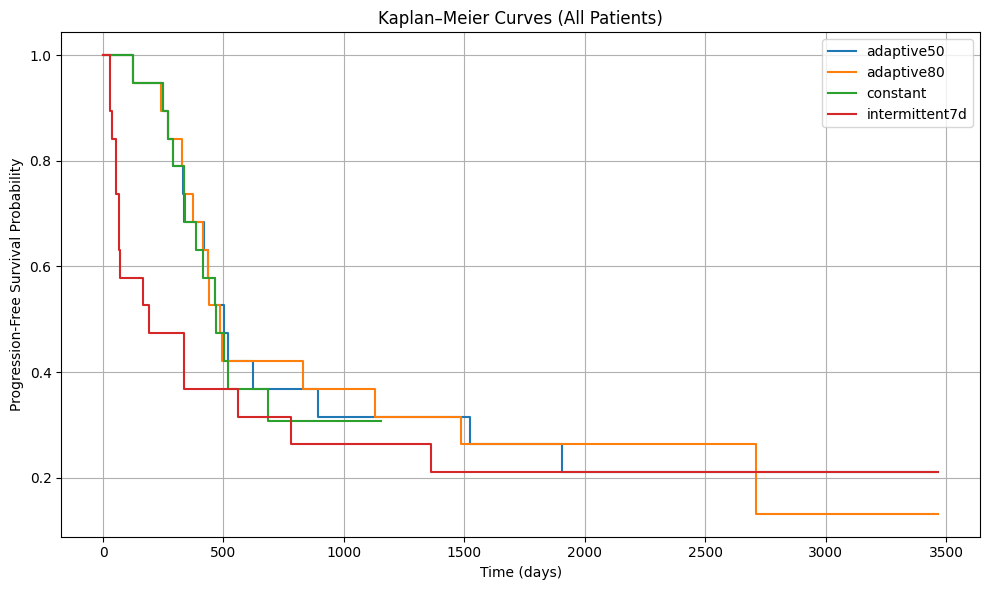

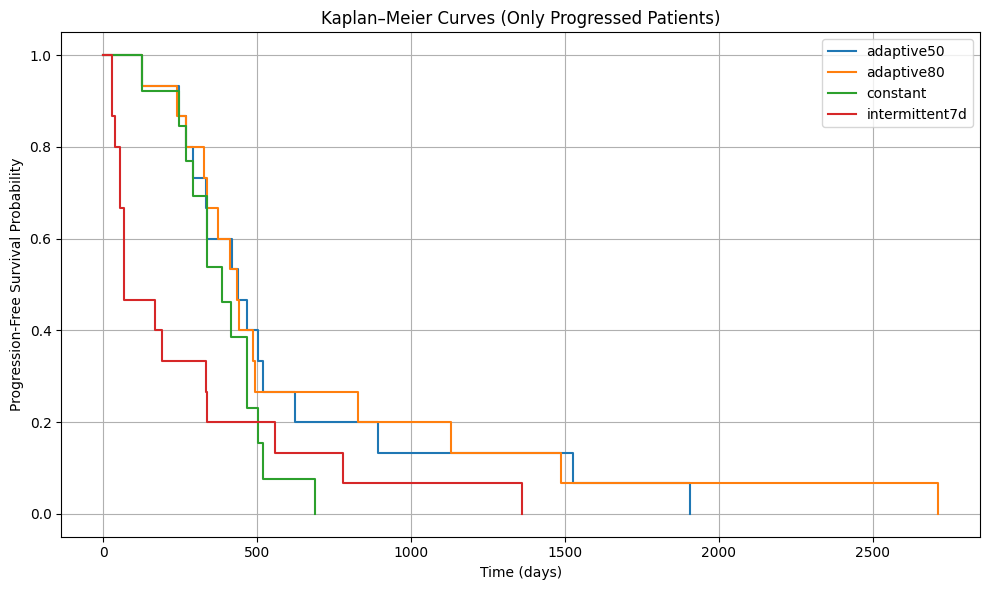


Log-Rank Tests (All Patients):
| Comparison         | χ²    | p-value |
|--------------------|-------|---------|
| constant vs adaptive50    |  0.04 | 0.8323 |
| constant vs adaptive80    |  0.08 | 0.7768 |
| constant vs intermittent7d |  1.27 | 0.2590 |

Log-Rank Tests (Only Progressed Patients):
| Comparison         | χ²    | p-value |
|--------------------|-------|---------|
| constant vs adaptive50    |  1.56 | 0.2112 |
| constant vs adaptive80    |  1.56 | 0.2111 |
| constant vs intermittent7d |  0.75 | 0.3857 |

Median and Mean PFS for Progressed Patients:
| Strategy       | Median (days) | Mean (days) |
|----------------|---------------|-------------|
| constant       |         385.0 |       388.9 |
| adaptive80     |         436.0 |       673.7 |
| adaptive50     |         437.0 |       593.1 |
| intermittent7d |          69.0 |       275.9 |


In [2]:
# Import required libraries for survival analysis and plotting
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === STEP 1: Convert tumor growth trajectories into survival events ===
# For each simulated patient-strategy combination, determine if and when tumor progression occurred
km_records = []

for i, row in surv_df.iterrows():
    N = row['N']               # Tumor size trajectory (array)
    t = row['time']            # Time points corresponding to N
    baseline = row['N0']       # Initial tumor size
    threshold = 1.2 * baseline # Define progression as a 20% increase from baseline

    # Determine earliest time at which progression occurred
    progression_idx = np.where(N >= threshold)[0]
    if len(progression_idx) > 0:
        time_to_event = t[progression_idx[0]]
        event_occurred = 1     # Event (progression) occurred
    else:
        time_to_event = t[-1]  # No progression; censor at final time point
        event_occurred = 0

    # Store event record for this patient-strategy combo
    km_records.append({
        'patient': row['patient'],
        'strategy': row['strategy'],
        'time': time_to_event,
        'event': event_occurred
    })

# Create structured DataFrame suitable for Kaplan–Meier fitting
km_df = pd.DataFrame(km_records)

# === STEP 2: Kaplan–Meier curves for all patients (including censored) ===
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Fit and plot the KM curve for each treatment strategy
for strategy in sorted(km_df['strategy'].unique()):
    group = km_df[km_df['strategy'] == strategy]
    kmf.fit(group['time'], event_observed=group['event'], label=strategy)
    kmf.plot_survival_function(ci_show=False)  # Plot without confidence intervals

# Plot formatting
plt.title('Kaplan–Meier Curves (All Patients)')
plt.xlabel('Time (days)')
plt.ylabel('Progression-Free Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 3: Kaplan–Meier curves for only patients who progressed ===
# This visualizes only the subpopulation where an event actually occurred
progressed_df = km_df[km_df['event'] == 1]

plt.figure(figsize=(10, 6))
for strategy in sorted(progressed_df['strategy'].unique()):
    group = progressed_df[progressed_df['strategy'] == strategy]
    kmf.fit(group['time'], event_observed=group['event'], label=strategy)
    kmf.plot_survival_function(ci_show=False)

plt.title('Kaplan–Meier Curves (Only Progressed Patients)')
plt.xlabel('Time (days)')
plt.ylabel('Progression-Free Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 4: Log-rank tests comparing each strategy against the control group ('constant') ===
# These tests evaluate whether survival distributions differ significantly

control = 'constant'
A_all = km_df[km_df['strategy'] == control]              # Control group for full dataset
A_prog = progressed_df[progressed_df['strategy'] == control]  # Control group for progressed-only subset

print("\nLog-Rank Tests (All Patients):")
print("| Comparison         | χ²    | p-value |")
print("|--------------------|-------|---------|")
for strat in sorted(km_df['strategy'].unique()):
    if strat == control:
        continue
    B = km_df[km_df['strategy'] == strat]
    res = logrank_test(A_all['time'], B['time'], A_all['event'], B['event'])
    print(f"| {control} vs {strat:<13} | {res.test_statistic:5.2f} | {res.p_value:.4f} |")

print("\nLog-Rank Tests (Only Progressed Patients):")
print("| Comparison         | χ²    | p-value |")
print("|--------------------|-------|---------|")
for strat in sorted(progressed_df['strategy'].unique()):
    if strat == control:
        continue
    B = progressed_df[progressed_df['strategy'] == strat]
    res = logrank_test(A_prog['time'], B['time'], A_prog['event'], B['event'])
    print(f"| {control} vs {strat:<13} | {res.test_statistic:5.2f} | {res.p_value:.4f} |")

# === STEP 5: Print summary table with median and mean PFS (for progressed patients only) ===
# This helps interpret the central tendency of survival distributions
stats = {}

# Compute median and mean PFS for progressed patients only
stats = {}
for strategy in progressed_df['strategy'].unique():
    times = progressed_df[progressed_df['strategy'] == strategy]['time']
    median_val = times.median()
    mean_val = times.mean()
    stats[strategy] = (median_val, mean_val)

print("\nMedian and Mean PFS for Progressed Patients:")
print("| Strategy       | Median (days) | Mean (days) |")
print("|----------------|---------------|-------------|")
for strat, (median_val, mean_val) in stats.items():
    print(f"| {strat:<14} | {median_val:13.1f} | {mean_val:11.1f} |")



# Cumulative treatment burden analysis across the different dosing strategies

This code calculates and compares the cumulative treatment exposure (in days) for each strategy, truncated to the duration of the standard MTD ("constant") simulation. Mean and median values are visualized for aligned comparison.


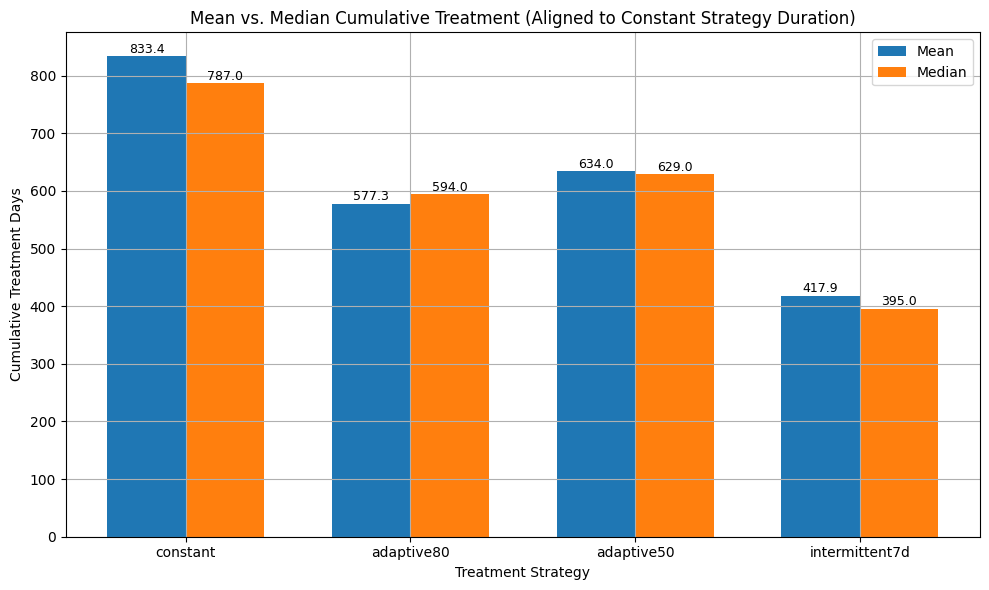

In [3]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === STEP 1: Organize simulated time series data by patient and treatment strategy ===
# We store each patient-strategy pair as a nested dictionary from the main survival DataFrame
patient_data = defaultdict(dict)
for i, row in surv_df.iterrows():
    patient_id = row['patient']
    strategy = row['strategy']
    patient_data[patient_id][strategy] = row

# === STEP 2: Compute cumulative treatment doses, aligned to MTD (constant strategy) duration ===
# We use the duration of the 'constant' simulation as a reference to truncate all other strategies
aligned_cumulative_doses = defaultdict(list)

for patient_id, strategies in patient_data.items():
    if 'constant' not in strategies:
        continue  # Skip patients without constant treatment data

    # Use the number of simulated time points from the 'constant' strategy as reference duration
    ref_len = len(strategies['constant']['time'])

    # For each strategy applied to this patient, compute treatment exposure within that window
    for strat, row in strategies.items():
        treatment = np.array(row['treatment_on'])[:ref_len]  # truncate to same length
        dose = treatment.sum()  # cumulative dose = total days treatment was ON
        aligned_cumulative_doses[strat].append(dose)

# === STEP 3: Calculate mean and median cumulative doses per strategy ===
# This summarizes central tendency of treatment burden across the cohort
aligned_summary = {
    strat: {
        'mean_cumulative_treatment': np.mean(doses),
        'median_cumulative_treatment': np.median(doses)
    }
    for strat, doses in aligned_cumulative_doses.items()
}

# === STEP 4: Create grouped bar chart to visualize mean vs. median per strategy ===
strategies = list(aligned_summary.keys())
means = [aligned_summary[s]['mean_cumulative_treatment'] for s in strategies]
medians = [aligned_summary[s]['median_cumulative_treatment'] for s in strategies]

x = np.arange(len(strategies))  # numerical x-position for each strategy
width = 0.35

# === STEP 5: Plot mean vs. median cumulative treatment ===
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, means, width, label='Mean')
bars2 = ax.bar(x + width/2, medians, width, label='Median')

# Annotate bars with values
for i, (mean, median) in enumerate(zip(means, medians)):
    ax.text(x[i] - width/2, mean + 1, f'{mean:.1f}', ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width/2, median + 1, f'{median:.1f}', ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_xlabel('Treatment Strategy')
ax.set_ylabel('Cumulative Treatment Days')
ax.set_title('Mean vs. Median Cumulative Treatment (Aligned to Constant Strategy Duration)')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


